# Twitter API v2

**Tutorial:** https://towardsdatascience.com/an-extensive-guide-to-collecting-tweets-from-twitter-api-v2-for-academic-research-using-python-3-518fcb71df2a


**Steps**

1. Introduction
2. Prerequisites to Start
3. Bearer Token
4. Create Headers
5. Create URL
	- search url
	- query params
6. Connect to Endpoint
7. Call the API endpoint
	- data
	- meta
8. Save Results to CSV
9. Looping Through Requests

> If we just send a request to collect tweets between the 1st of January 2020 and the 31st of December 2020, we will hit our cap very quickly without having a good distribution from all 12 months.
So what we can do is, we can set a limit for tweets we want to collect per month, so that if we reach the specific cap at one month, we move on to the next one.

* A For-loop that goes over the months/weeks/days we want to cover (Depending on how it is set)

* A While-loop that controls the maximum number of tweets we want to collect per time period.

* Notice that a time.sleep() is added between calls to ensure you are not just spamming the API with requests.

In [13]:
# 2. Prerequisites to Start

# For sending GET requests from the API
import requests
# For saving access tokens and for file management when creating and adding to the dataset
import os
# For dealing with json responses we receive from the API
import json
# For displaying the data after
import pandas as pd
# For saving the response data in CSV format
import csv
# For parsing the dates received from twitter in readable formats
import datetime
import dateutil.parser
import unicodedata
#To add wait time between requests
import time

import yaml

In [2]:
# 3. Bearer token
def auth():
    with open("../config.yaml") as file:
        passwords = yaml.safe_load(file)
    return passwords["search_tweets_api"]["bearer_token"]

In [3]:
# 4. Create Headers
def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

In [4]:
# 5. Create url
def create_url(keyword, start_date, end_date, max_results = 10):
    
    search_url = "https://api.twitter.com/2/tweets/search/all" #Change to the endpoint you want to collect data from

    #change params based on the endpoint you are using
    query_params = {'query': keyword,
                    'start_time': start_date,
                    'end_time': end_date,
                    'max_results': max_results,
                    'tweet.fields': 'id,text,author_id,created_at,public_metrics',
                    # 'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
                    # 'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
                    # 'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
                    # 'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                    'next_token': {}}
    return (search_url, query_params)

In [5]:
# 6. Connect to endpoint
def connect_to_endpoint(url, headers, params, next_token = None):
    params['next_token'] = next_token   #params object received from create_url function
    response = requests.request("GET", url, headers = headers, params = params)
    print("Endpoint Response Code: " + str(response.status_code))
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

In [6]:
## // Inputs for the request //
bearer_token = auth()
headers = create_headers(bearer_token)

# keyword = "ethereum -is:retweet lang:en"
keyword = "Vizag gas leak"

start_time = "2020-05-07T00:00:00.000Z"
end_time = "2020-05-12T00:00:00.000Z"
max_results = 50

In [7]:
## // Call the API //
url = create_url(keyword, start_time,end_time, max_results)
json_response = connect_to_endpoint(url[0], headers, url[1])
print(json.dumps(json_response, indent=4, sort_keys=True))

Endpoint Response Code: 200
{
    "data": [
        {
            "author_id": "1210423564052004865",
            "created_at": "2020-05-11T23:59:53.000Z",
            "id": "1259996683464699904",
            "public_metrics": {
                "like_count": 1,
                "quote_count": 0,
                "reply_count": 0,
                "retweet_count": 0
            },
            "text": "Vizag gas leak: Former AP CM Chandrababu Naidu writes to PM, asks for scientific probe https://t.co/gQesZTr9Z5"
        },
        {
            "author_id": "1210423564052004865",
            "created_at": "2020-05-11T23:56:54.000Z",
            "id": "1259995931514007553",
            "public_metrics": {
                "like_count": 0,
                "quote_count": 0,
                "reply_count": 0,
                "retweet_count": 0
            },
            "text": "Vizag gas leak: LG Polymer plant ducked safety scrutiny https://t.co/ztkiDUVEIQ"
        },
        {
            "auth

In [8]:
## Save Results
def append_to_csv(json_response, fileName):

    #A counter variable
    counter = 0

    #Open OR create the target CSV file
    csvFile = open(fileName, "a", newline="", encoding='utf-8')
    csvWriter = csv.writer(csvFile)

    #Loop through each tweet
    for tweet in json_response['data']:
        
        # We will create a variable for each since some of the keys might not exist for some tweets
        # So we will account for that

        # 1. Author ID
        author_id = tweet['author_id']

        # 2. Time created
        created_at = dateutil.parser.parse(tweet['created_at'])

        # 3. Tweet ID
        tweet_id = tweet['id']

        # 6. Tweet metrics
        retweet_count = tweet['public_metrics']['retweet_count']
        reply_count = tweet['public_metrics']['reply_count']
        like_count = tweet['public_metrics']['like_count']
        quote_count = tweet['public_metrics']['quote_count']

        # 8. Tweet text
        text = tweet['text']
        
        # Assemble all data in a list
        # 'author_id', 'created_at', 'tweet_id', 'text', 'like_count', 'quote_count', 'reply_count', 'retweet_count'
        res = [author_id, created_at, tweet_id, text, like_count, quote_count, reply_count, retweet_count]
        
        # Append the result to the CSV file
        csvWriter.writerow(res)
        counter += 1

    # When done, close the CSV file
    csvFile.close()

    # Print the number of tweets for this iteration
    print("# of Tweets added from this response: ", counter) 

In [9]:
# Create file
csvFile = open("vizag_gas_leak_twitter_api.csv", "a", newline="", encoding='utf-8')
csvWriter = csv.writer(csvFile)

#Create headers for the data you want to save, in this example, we only want save these columns in our dataset
csvWriter.writerow([ 'author_id', 'created_at', 'tweet_id', 'text', 'like_count', 'quote_count', 'reply_count', 'retweet_count'])
csvFile.close()

append_to_csv(json_response=json_response, fileName="vizag_gas_leak_twitter_api.csv")

# of Tweets added from this response:  48


In [14]:
## // Store collected tweets in a pickle file //

# import pandas as pd
# from pandas import json_normalize 
# df = json_normalize(json_response, 'data')
# display(df)
# print(df.columns)
# df.to_pickle('data/collected_tweets.pkl')
# df = pd.read_pickle('data/collected_tweets.pkl')

In [15]:
## // Store the data in Human readable format (collected_tweets.txt) // 
# but also store the data in a pickle dataframe ready to be processed using pandas.

# keys = json_response["data"][0].keys()
# print(keys)

# with open('../data/collected_tweets.txt', 'a') as outfile:
#     for i in range(len(json_response["data"])):
#         json.dump(json_response["data"][i], outfile)
#         outfile.write('\n')

# Pagination (Loops)

In [11]:
start_list =    ['2020-05-07T00:00:00.000Z',
                 '2020-05-08T00:00:00.000Z',
                 '2020-05-09T00:00:00.000Z',
                 '2020-05-10T00:00:00.000Z',
                 '2020-05-11T00:00:00.000Z',
                 '2020-05-12T00:00:00.000Z']

end_list =      ['2020-05-08T00:00:00.000Z',
                 '2020-05-09T00:00:00.000Z',
                 '2020-05-10T00:00:00.000Z',
                 '2020-05-11T00:00:00.000Z',
                 '2020-05-12T00:00:00.000Z',
                 '2020-05-13T00:00:00.000Z']

In [12]:
#Inputs for tweets
bearer_token = auth()
headers = create_headers(bearer_token)
keyword = "Vizag gas leak -is:retweet"
datafile = "../data/vizag_gas_leak_twitter_api.csv"

max_results = 500 # total results per API call


#Total number of tweets we collected from the loop
total_tweets = 0

# Create file
csvFile = open(datafile, "a", newline="", encoding='utf-8')
csvWriter = csv.writer(csvFile)

# (Only the first time)
# Create headers for the data you want to save, in this example, we only want save these columns in our dataset
csvWriter.writerow(['author_id', 'created_at', 'tweet_id', 'text',
                    'like_count', 'quote_count', 'reply_count', 'retweet_count'])

csvFile.close()

for i in range(0,len(start_list)):

    # Inputs
    count = 0 # Counting tweets per time period
    max_count = 10_000 # Max tweets per time period
    flag = True
    next_token = None
    
    # Check if flag is true
    while flag:
        
        # Check if max_count reached
        if count >= max_count:
            break
        print("-------------------")
        print("Token: ", next_token)
        url = create_url(keyword, start_list[i],end_list[i], max_results)
        json_response = connect_to_endpoint(url[0], headers, url[1], next_token)
        result_count = json_response['meta']['result_count']

        if 'next_token' in json_response['meta']:
            # Save the token to use for next call
            next_token = json_response['meta']['next_token']
            print("Next Token: ", next_token)
            if result_count is not None and result_count > 0 and next_token is not None:
                print("Start Date: ", start_list[i])
                append_to_csv(json_response, datafile)
                count += result_count
                total_tweets += result_count
                print("Total # of Tweets added: ", total_tweets)
                print("-------------------")
                time.sleep(5)                
        
        # If no next token exists
        else:
            if result_count is not None and result_count > 0:
                print("-------------------")
                print("Start Date: ", start_list[i])
                append_to_csv(json_response, datafile)
                count += result_count
                total_tweets += result_count
                print("Total # of Tweets added: ", total_tweets)
                print("-------------------")
                time.sleep(5)
            
            #Since this is the final request, turn flag to false to move to the next time period.
            flag = False
            next_token = None
        
        time.sleep(2)
        
print("Total number of results: ", total_tweets)

-------------------
Token:  None
Endpoint Response Code: 200
Next Token:  b26v89c19zqg8o3fo7agi6c5u97zlzaxikcazpqh7pbi5
Start Date:  2020-05-07T00:00:00.000Z
# of Tweets added from this response:  494
Total # of Tweets added:  494
-------------------
-------------------
Token:  b26v89c19zqg8o3fo7agi6c5u97zlzaxikcazpqh7pbi5
Endpoint Response Code: 200
Next Token:  b26v89c19zqg8o3fo7agi6b9dxmsfvxzcv3xeuimx58jh
Start Date:  2020-05-07T00:00:00.000Z
# of Tweets added from this response:  496
Total # of Tweets added:  990
-------------------
-------------------
Token:  b26v89c19zqg8o3fo7agi6b9dxmsfvxzcv3xeuimx58jh
Endpoint Response Code: 200
Next Token:  b26v89c19zqg8o3fo7agi6ad9qlpdkhfq6jqwp3e3b4al
Start Date:  2020-05-07T00:00:00.000Z
# of Tweets added from this response:  500
Total # of Tweets added:  1490
-------------------
-------------------
Token:  b26v89c19zqg8o3fo7agi6ad9qlpdkhfq6jqwp3e3b4al
Endpoint Response Code: 200
Next Token:  b26v89c19zqg8o3fo7agi481fu2iqf5c1au81267tx665
Sta

# EDA collected dataset

In [18]:
import pandas as pd

In [19]:
df = pd.read_csv("../data/vizag_gas_leak_twitter_api.csv")

In [20]:
df.shape

(12201, 8)

In [21]:
df.head()

,author_id,"""created_at""","""tweet_id""",text,like_count,quote_count,reply_count,retweet_count
0,1210423564052004865,2020-05-07 23:59:53+00:00,1258547131083665409,"Vizag gas leak: Thousands fall sick, govt soun...",0,0,0,0
1,1210423564052004865,2020-05-07 23:57:45+00:00,1258546596288925697,Vizag gas leak: Watch shocking footages from t...,0,0,0,0
2,1210423564052004865,2020-05-07 23:56:11+00:00,1258546198941544448,Vizag gas leak: Tragic Thursday for thousands ...,0,0,0,0
3,2577333854,2020-05-07 23:49:26+00:00,1258544502777638913,Gas leak at South Korea-owned #LGPolymers fact...,0,0,0,0
4,1241399143890731008,2020-05-07 23:46:02+00:00,1258543645625511937,Vizag Gas Leak: Cine Personalities Express Sho...,0,0,0,0


In [25]:
df["author_id"].nunique()/len(df)

0.6111794115236456

## WordCloud

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(13,6)})
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [40]:
# WordCloud?

In [41]:
# Concatanate tweets on a single string
text = " ".join(txt for txt in df["text"])
total_words = len(text)
print (f"There are {total_words} words in the combination of all tweets.")

# Lower case the words
text = text.lower()

unique_words = set(text)
total_unique_words = len(unique_words)
print (f"The unique words are {total_unique_words}")

There are 2027449 words in the combination of all tweets.
The unique words are 1535


In [42]:
# unique_words

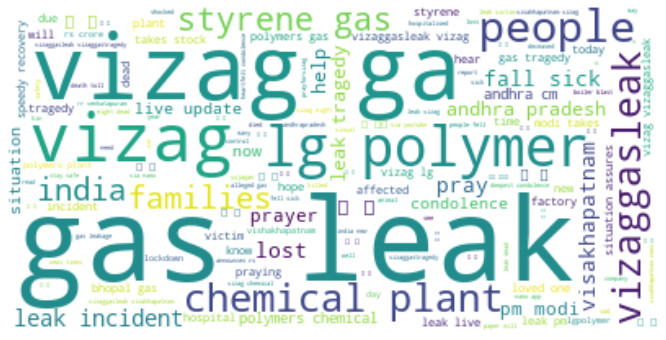

In [46]:
# Create stopword list and update it with other common words
stopwords = set(STOPWORDS)
stopwords.update(["amp", "https", "t", "co", "t co",
                  "https t"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [47]:
# Most common words
wordcloud.words_

{'gas leak': 1.0,
 'vizag ga': 0.5486915069559296,
 'vizag': 0.2615040373577196,
 'lg polymer': 0.1775464539352077,
 'people': 0.10078801439828777,
 'chemical plant': 0.08531958361708337,
 'vizaggasleak': 0.0788987255569608,
 'styrene gas': 0.06313843759120537,
 'india': 0.05457729351104193,
 'families': 0.053118007588286796,
 'leak incident': 0.05233972176281739,
 'ग स': 0.04630800661542952,
 'fall sick': 0.04445957777993968,
 'pray': 0.04377857768265395,
 'lost': 0.043486720498102927,
 'visakhapatnam': 0.041443720206245746,
 'andhra pradesh': 0.03871971981710283,
 'help': 0.0384278626325518,
 'leak tragedy': 0.03833057690436813,
 'pm modi': 0.03512014787430684,
 'prayer': 0.03424457632065376,
 'ल ग': 0.034147290592470084,
 'live update': 0.033660861951551706,
 'now': 0.03190971884424555,
 'ल क': 0.0317151473878782,
 'condolence': 0.0313260044751435,
 'situation': 0.03122871874695982,
 'polymers chemical': 0.029380289911469987,
 'andhra cm': 0.02908843272691896,
 'vizaggasleak vizag':